# <center> Walmart Sales Prediction

Walmart is a renowned retail corporation that operates a chain of hypermarkets. Here, Walmart has provided a data combining of 45 stores including store information and monthly sales. The data is provided on weekly basis. Walmart tries to find the impact of holidays on the sales of store. For which it has included four holidays’ weeks into the dataset which are Christmas, Thanksgiving, Super bowl, Labor Day. Here we are owing to Analyze the dataset given. Before doing that, let me point out the objective of this analysis. 

### Assume you are a ML Scientist at Walmart and you are given the following business objective

# Business Objectives

Our Main Objective is to predict sales of store in a week. As in dataset size and time related data are given as feature, so analyze if sales are impacted by time-based factors and space- based factor. Most importantly how inclusion of holidays in a week soars the sales in store? 

# Importing Necessary Libraries and Data

In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")



pd.options.display.max_columns=100 # to see columns 


     |████████████████████████████████| 1.4 MB 537 kB/s            


### Read Data

In [2]:
df_store = pd.read_csv('../input/walmart-sales-forecast/stores.csv') #store data

In [3]:
df_train = pd.read_csv('../input/walmart-sales-forecast/train.csv') # train set

In [4]:
df_features = pd.read_csv('../input/walmart-sales-forecast/features.csv') #external information

### Dataset eyeballing

There are two ways to eyeball datasets in pandas
1.  Use head() / tail() command to see few rows
2.  Using describe() to get basic summary statistics of numerical column - you can also think of this as a part of EDA.

Use the next few cells you will  eyeball to help you prepare your data better. Note down you high level observations.

In [5]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## Data Preparation

ML Scientist should always look to collect and leverage more data.

1. For each store we have the weekly sale data - which is the primary data source for weekly sale prediction
2. We also have store related information
3. There additional macroeconomic and holiday related features.

### Task 1
Combine the 3 datasets into one dataframe. This will help you to get all your data in a single table

 ### Task 2
Discuss on the type of the join (left, right, inner, cross) to be used and implications. Make appropriate assumptions to support your decision wherever needed.

### Task 3
How to check data sanity post your joins?


In [8]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='left').merge(df_store, on=['Store'], how='left')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [9]:
 # removing dublicated column

In [10]:
df.drop('IsHoliday_y', axis=1, inplace=True)
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [11]:
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [12]:
df.shape

(421570, 16)

### Sanity Checks


In [13]:
df['Store'].nunique() # number of different values

45

In [14]:
df['Dept'].nunique() # number of different values

81

## Dervied Features
In addition to the features we get from raw data, we can add derived features as well. In the current exercise, there is a date field. We can derive weekday, month, year. Also we can map quater corresponding to the date.

In [15]:
df.Date=pd.to_datetime(df.Date)

df['week'] = df.Date.dt.week
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

# you can also map quarter if you want using
#df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

#df.drop(['Date'], axis=1, inplace=True)#,'month'

numericalFeatures = ['Temperature','CPI','Unemployment','Size']
categoricalFeatures = ['year','month','IsHoliday','Type','week']

idFeatures = ['Dept','Store']

#unUsedFeature = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

#df.drop(unUsedFeature, axis=1, inplace=True)

In [16]:
#seggregate features and target
target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,3,2010


## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is probably one of the most frequent term heard in ML. The objective of EDA is to explore and understand your data. There are two most popular ways we can do that:

1. Looking at descriptive statistics of features - mean, median, mode (categorical), percentile distribution, frequency (categorical)
2. Vizualizing the distribution of the features - box plot, bar plot, histogram, density plots

There are many ways to do EDA. But there are standard plots, statistics which are used in general. However you should think of interesting ways to vizualize and understand your data.
The key part of EDA is what insight are you getting and what can we do about those insights?

### Task1
Vizualize each features - using box plot

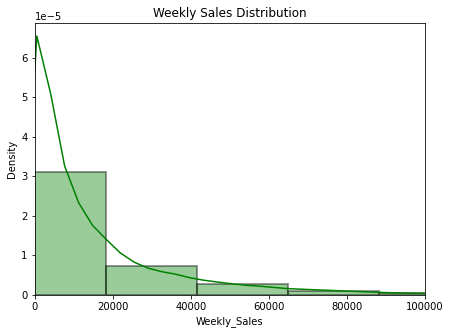

In [17]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[7,5])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Weekly Sales Distribution')
plt.xlim(0, 100000)
plt.show()

### Box Plots

                                                Numeric Features Distribution                                                 


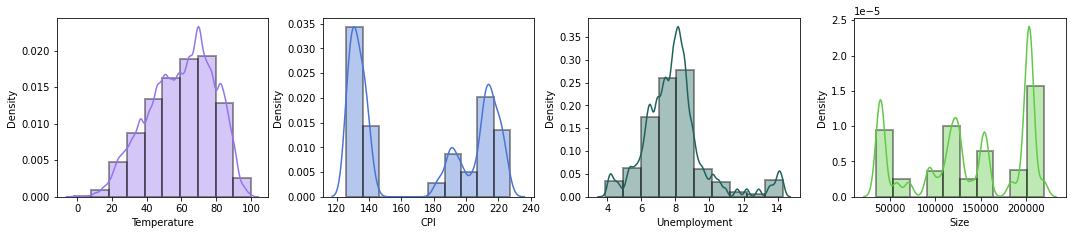

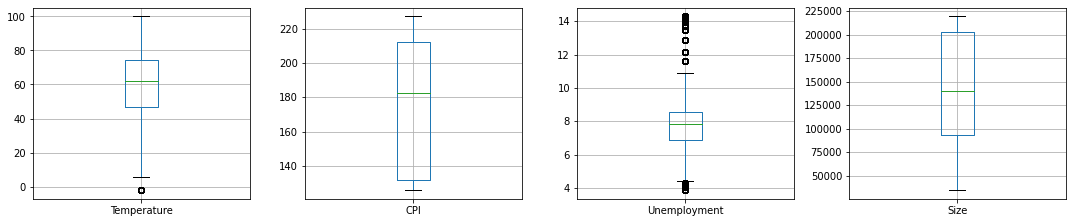

In [18]:
print('\033[1mNumeric Features Distribution'.center(130))

n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(numericalFeatures)/n)])
for i in range(len(numericalFeatures)):
    plt.subplot(math.ceil(len(numericalFeatures)/3),n,i+1)
    sns.distplot(df[numericalFeatures[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(numericalFeatures)/n)])
for i in range(len(numericalFeatures)):
    plt.subplot(math.ceil(len(numericalFeatures)/3),n,i+1)
    df.boxplot(numericalFeatures[i])
plt.tight_layout()
plt.show()

### Pivot table
Pivot tables are one of the most versatile way to vizualize data across multiple dimensions. In the following cell try to vizualize the weekly sales for each store and department.

In [19]:
dimesnion_1 = 'Store'
dimension_2 = 'Dept'
variable = 'Weekly_Sales'
aggFunction = np.mean

store_dept_table = pd.pivot_table(df, index=dimesnion_1, columns=dimension_2,
                                  values= variable, aggfunc=aggFunction)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

## What are your insights?
Hints:
1. Do you observe an discrepancy in the number of unique department and Dept field
2. Are there departments with zero sales for a store? What to do about them? Make appropriate assumptions
3. Are there departments with negative sales? What to do about them? Make appropriate assumptions

In [20]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315,32,8,2012
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,A,151315,18,5,2012
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2,2010
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315,10,3,2010
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315,40,10,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221,6,2,2010
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221,7,2,2010
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221,15,4,2010
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221,26,7,2010


1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [21]:
df = df.loc[df['Weekly_Sales'] > 0]

In [22]:
df.shape # new data shape

(420212, 19)

### Vizualizing Categorical Variable
We will be using Barplot to vizualize categorical variables

In [23]:
len(categoricalFeatures)

5

In [24]:
categoricalFeatures

['year', 'month', 'IsHoliday', 'Type', 'week']

                               Visualising Categorical Features:                                


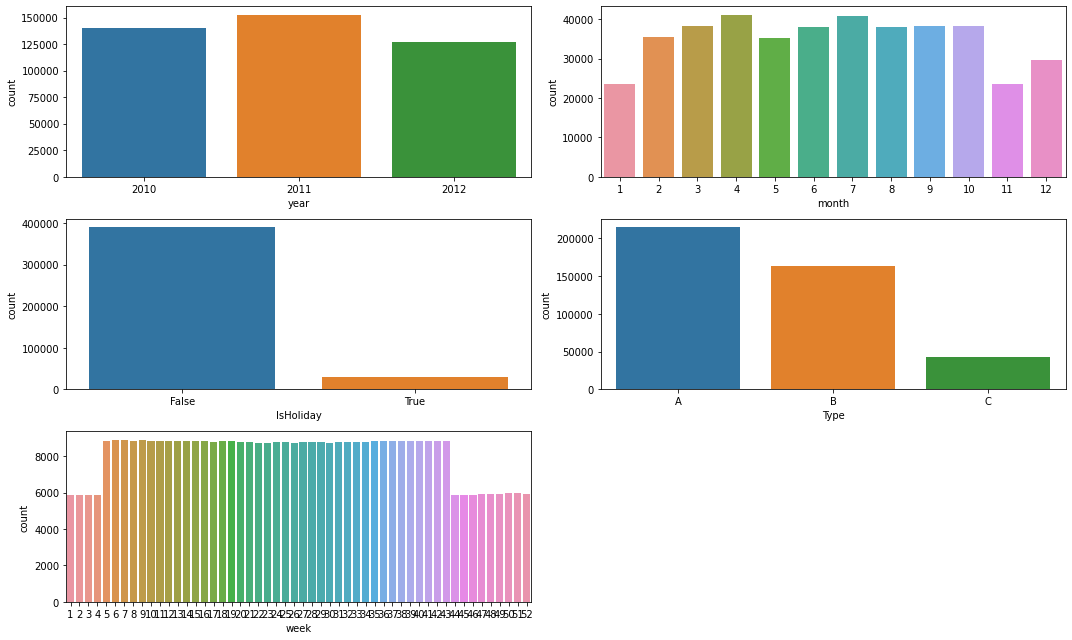

In [25]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(categoricalFeatures)/n)])

for i in range(len(categoricalFeatures)):
    if df[categoricalFeatures[i]].nunique()<=8:
        plt.subplot(math.ceil(len(categoricalFeatures)/n),n,i+1)
        sns.countplot(df[categoricalFeatures[i]])
    else:
        plt.subplot(math.ceil(len(categoricalFeatures)/n),n,i+1)
        sns.countplot(df[categoricalFeatures[i]])
        
plt.tight_layout()
plt.show()

In [26]:
df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.

0        2010-02-05
1        2010-02-12
2        2010-02-19
3        2010-02-26
4        2010-03-05
421565   2012-09-28
421566   2012-10-05
421567   2012-10-12
421568   2012-10-19
421569   2012-10-26
Name: Date, dtype: datetime64[ns]

Our data is from 5th of February 2010 to 26th of October 2012.  

# Exploring impact of Holiday

In [27]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Going one step ahead with Holidays
Holidays had enourmous affect on internet traffic. We managed to figure out the following date mapping

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False. 

In [28]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [29]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [30]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [31]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

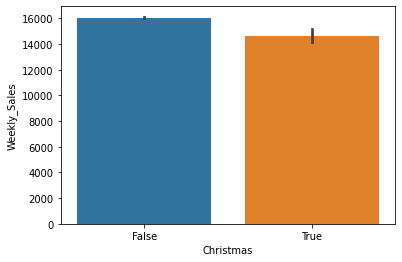

In [32]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

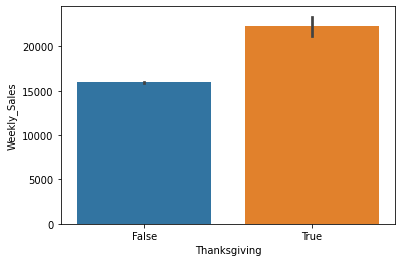

In [33]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

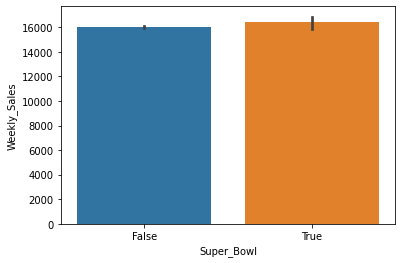

In [34]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

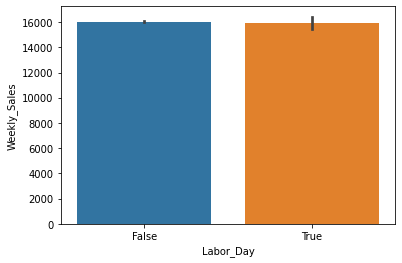

In [35]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

# Type Effect on Holidays

There are three different store types in the data as A, B and C.

In [36]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [37]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [38]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [39]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

I want to see percentages of store types.

In [40]:
typePercentage = df['Type'].value_counts(normalize=True)*100

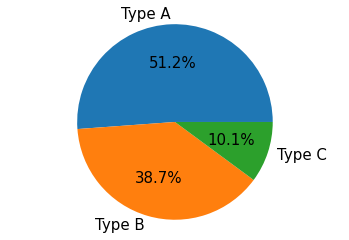

In [41]:
typePercent = list(typePercentage.values)  #percentages
typelabels = 'Type A','Type B', 'Type C' # labels
plt.pie(typePercent,labels=typelabels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [42]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

Nearly, half of the stores are belongs to Type A.

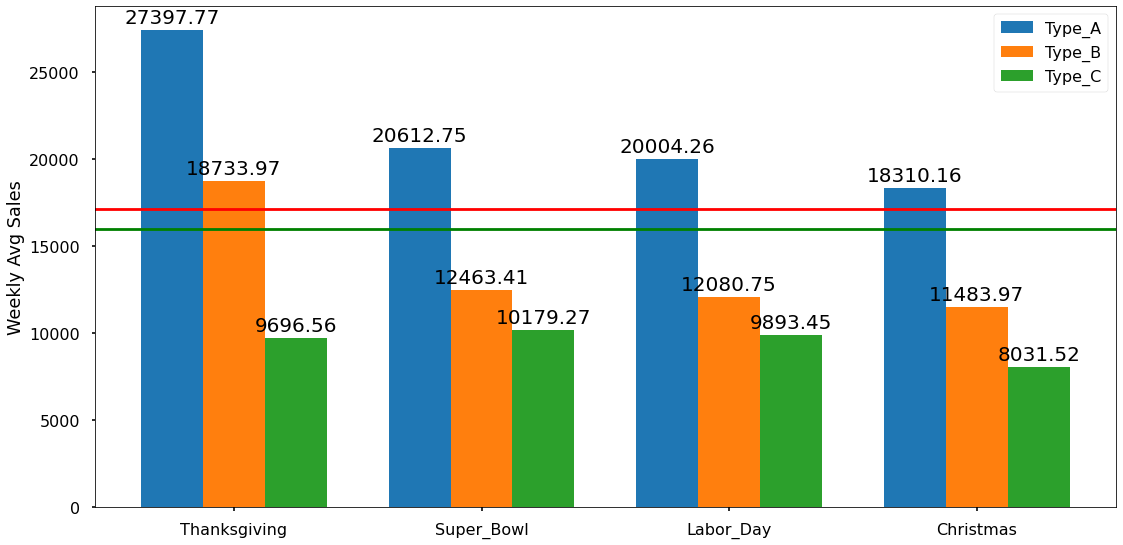

In [43]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [44]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year,Super_Bowl,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,47,11,2010,False,False,True,False
338013,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,47,11,2011,False,False,True,False
95425,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,47,11,2011,False,False,True,False
337961,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,47,11,2010,False,False,True,False
135665,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,47,11,2010,False,False,True,False


Also, it is not surprise that top 5 highest weekly sales are belongs to Thanksgiving weeks.

# To See the Size - Type Relation

In [45]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


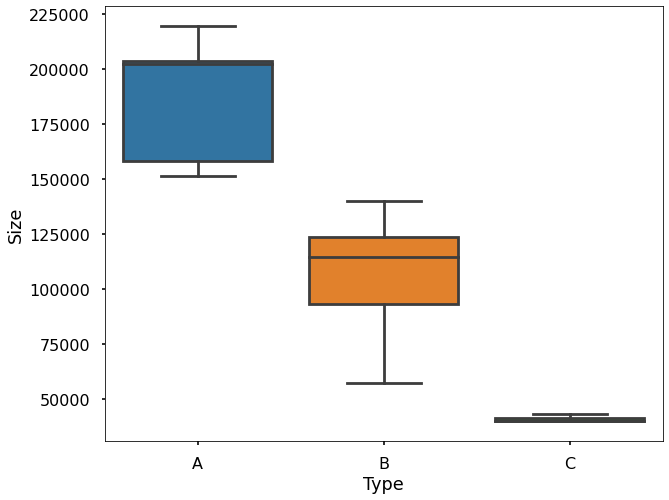

In [46]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

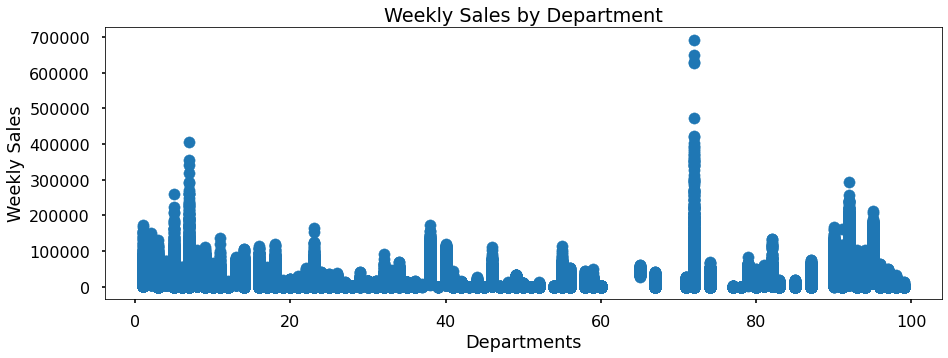

In [47]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

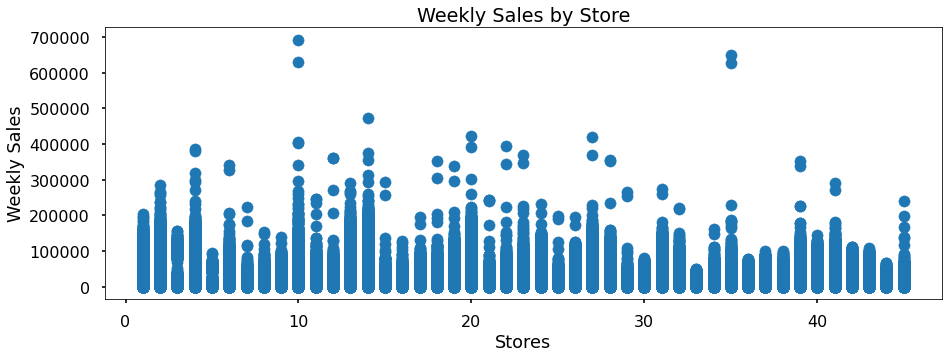

In [48]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

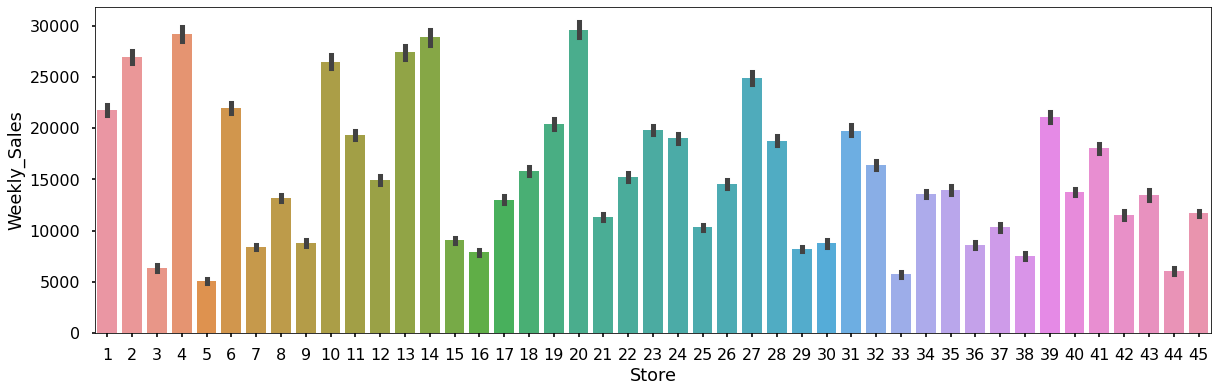

In [49]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

<AxesSubplot:xlabel='month'>

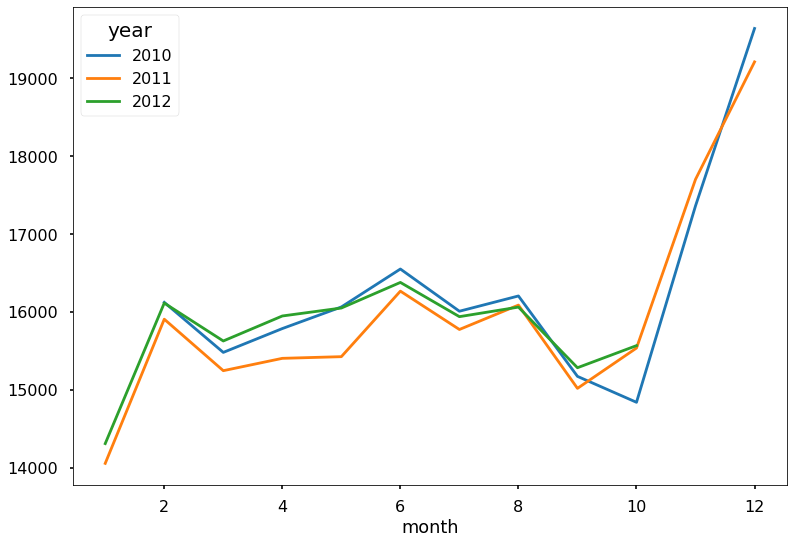

In [50]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

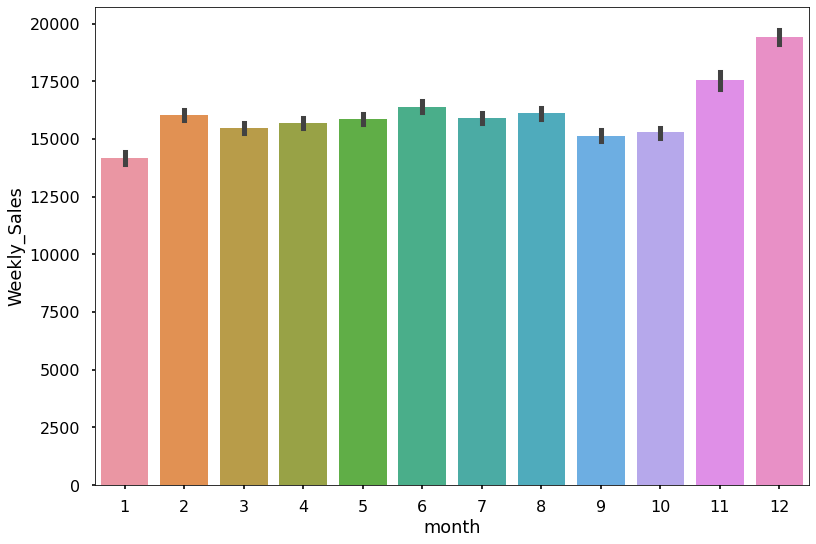

In [51]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

<AxesSubplot:xlabel='week'>

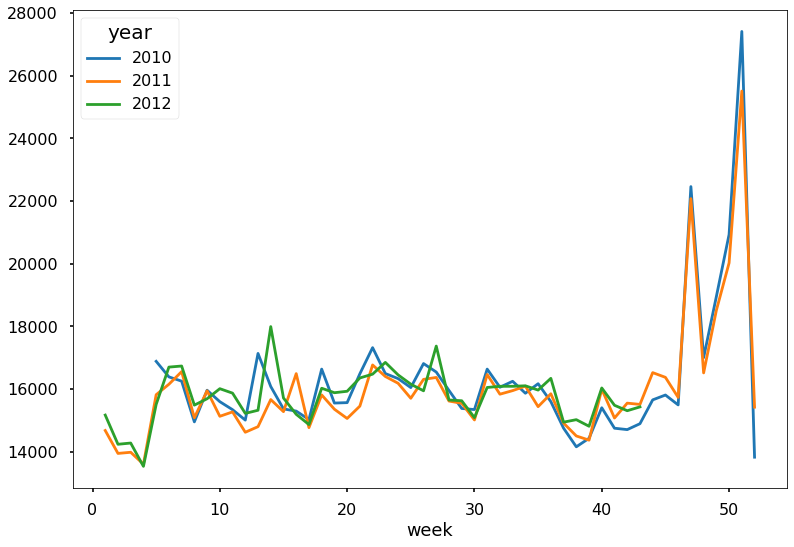

In [52]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

<AxesSubplot:xlabel='Fuel_Price'>

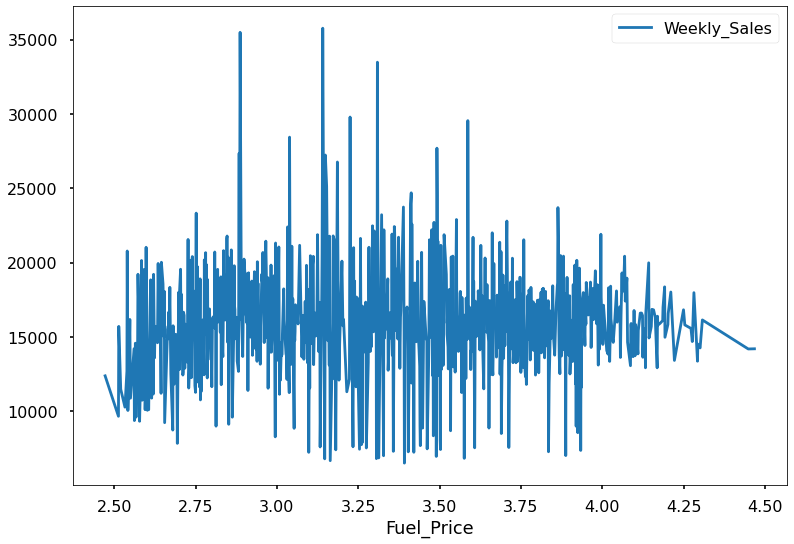

In [53]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<AxesSubplot:xlabel='Temperature'>

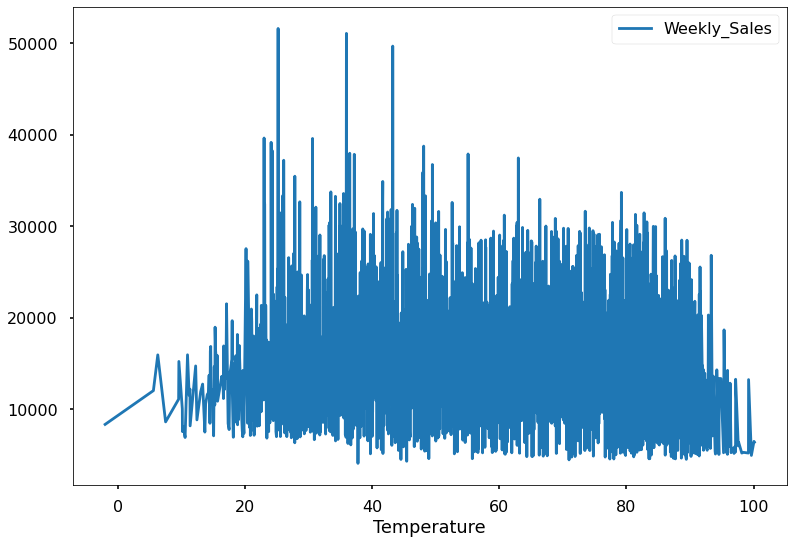

In [54]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<AxesSubplot:xlabel='CPI'>

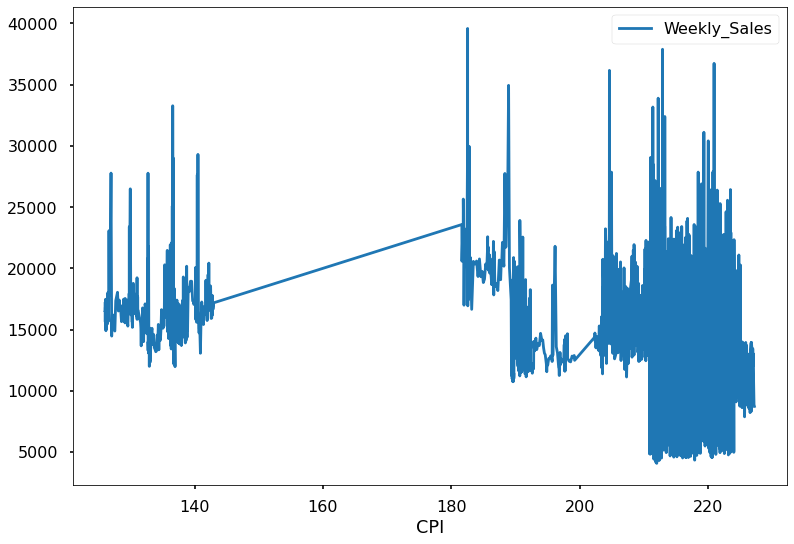

In [55]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<AxesSubplot:xlabel='Unemployment'>

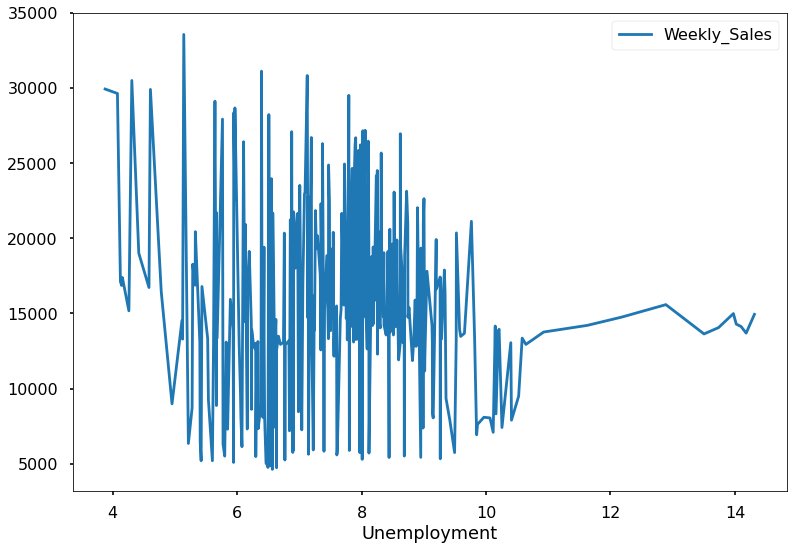

In [56]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

### Missing Value Treatment

Walmart gave markdown columns to see the effect if markdowns on sales. When I check columns, there are many NaN values for markdowns. I decided to change them with 0, because if there is markdown in the row, it is shown with numbres. So, if I can write 0, it shows there is no markdown at that date.

In [57]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

In [58]:
missing_value_df

,column_name,percent_missing
Store,Store,0.000000
Labor_Day,Labor_Day,0.000000
Super_Bowl,Super_Bowl,0.000000
year,year,0.000000
month,month,0.000000
week,week,0.000000
Size,Size,0.000000
Type,Type,0.000000
Unemployment,Unemployment,0.000000
CPI,CPI,0.000000


In [59]:
df = df.fillna(0) # filling null's with 0

In [60]:
df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
week            0
month           0
year            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [61]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,week,month,year
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787,25.828408,6.449866,2010.968454
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568,14.152489,3.243397,0.796898
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,14.000000,4.000000,2010.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000,26.000000,6.000000,2011.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000,38.000000,9.000000,2012.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,52.000000,12.000000,2012.000000


Minimum value for weekly sales is 0.01. Most probably, this value is not true but I prefer not to change them now. Because, there are many departments and many stores. It takes too much time to check each department for each store (45 store for 81 departments). So, I take averages for EDA. 

In [62]:
df['week'].nunique()

52

In [107]:
#Removal of outlier:

intermediateData = df.copy()


for i in numericalFeatures:
    Q1 = intermediateData[i].quantile(0.25)
    Q3 = intermediateData[i].quantile(0.75)
    IQR = Q3 - Q1
    intermediateData = intermediateData[intermediateData[i] <= (Q3+(1.5*IQR))]
    intermediateData = intermediateData[intermediateData[i] >= (Q1-(1.5*IQR))]
    intermediateData = intermediateData.reset_index(drop=True)
display(intermediateData.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(intermediateData.shape[0]))

,Temperature,CPI,Unemployment,Size,Dept,Store,Weekly_Sales,year,month,IsHoliday,Type,week,year_2011,year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Type_B,Type_C,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,42.31,211.096358,8.106,151315,1,1,24924.50,2010,2,0,A,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.51,211.242170,8.106,151315,1,1,46039.49,2010,2,1,A,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39.93,211.289143,8.106,151315,1,1,41595.55,2010,2,0,A,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,46.63,211.319643,8.106,151315,1,1,19403.54,2010,2,0,A,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,46.50,211.350143,8.106,151315,1,1,21827.90,2010,3,0,A,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 420212 samples.
After removal of outliers, The dataset now has 388101 samples.


In [108]:
#Removal of outlier:

intermediateData = df.copy()


intermediateData['isOutlier'] = False

for i in numericalFeatures:
    Q1 = intermediateData[i].quantile(0.25)
    Q3 = intermediateData[i].quantile(0.75)
    IQR = Q3 - Q1
    intermediateData['isOutlier'] = (intermediateData['isOutlier'] == True) | (intermediateData[i] > (Q3+(1.5*IQR))) | (intermediateData[i] < (Q1-(1.5*IQR)))
    
   
display(intermediateData[intermediateData['isOutlier'] == False].head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(intermediateData[intermediateData['isOutlier'] == False].shape[0]))

,Temperature,CPI,Unemployment,Size,Dept,Store,Weekly_Sales,year,month,IsHoliday,Type,week,year_2011,year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Type_B,Type_C,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,isOutlier
0,42.31,211.096358,8.106,151315,1,1,24924.50,2010,2,0,A,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,38.51,211.242170,8.106,151315,1,1,46039.49,2010,2,1,A,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,39.93,211.289143,8.106,151315,1,1,41595.55,2010,2,0,A,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,46.63,211.319643,8.106,151315,1,1,19403.54,2010,2,0,A,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,46.50,211.350143,8.106,151315,1,1,21827.90,2010,3,0,A,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False



Inference:
Before removal of outliers, The dataset had 420212 samples.
After removal of outliers, The dataset now has 388101 samples.


In [109]:
intermediateData = intermediateData[intermediateData['isOutlier'] == False].drop(['isOutlier'],axis = 1)

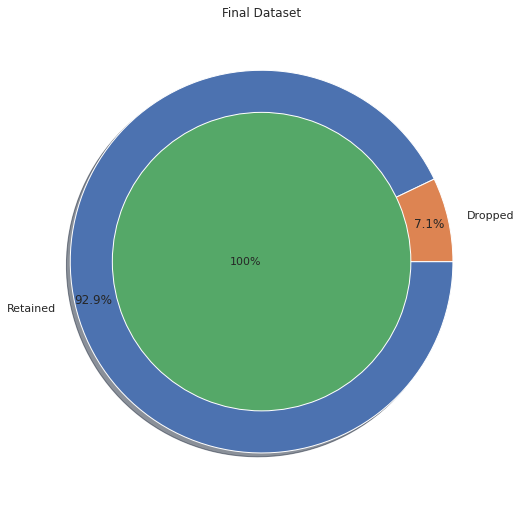


Inference: After the cleanup process, 32111 samples were dropped, while retaining 7.64% of the data.


In [110]:
#Final Dataset size after performing Preprocessing


plt.title('Final Dataset')
plt.pie([df.shape[0], df.shape[0]-intermediateData.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {df.shape[0]-intermediateData.shape[0]} samples were dropped, \
while retaining {round(100 - (intermediateData.shape[0]*100/(df.shape[0])),2)}% of the data.')

In [111]:
intermediateData.columns

Index(['Temperature', 'CPI', 'Unemployment', 'Size', 'Dept', 'Store',
       'Weekly_Sales', 'year', 'month', 'IsHoliday', 'Type', 'week',
       'year_2011', 'year_2012', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'Type_B', 'Type_C', 'week_2', 'week_3', 'week_4', 'week_5',
       'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51', 'week_52'],
      dtype='object')

In [112]:

X = intermediateData

Train_df, Test_df = train_test_split(X, train_size=0.8, test_size=0.2, random_state=100)
Test_df.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,'\nTraining set  ---> ',Train_df.shape,'\nTesting set   ---> ', Test_df.shape)

Original set  --->  (388101, 78) 
Training set  --->  (310480, 78) 
Testing set   --->  (77621, 78)


In [113]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

In [118]:
corrNummerical = Train_df[numericalFeatures+['Weekly_Sales']]
corr = corrNummerical.apply(lambda x: pd.factorize(x)[0]).corr()
corr['featureName'] = corr.index

corr = corr[corr['featureName'] != 'Weekly_Sales'][['featureName','Weekly_Sales']]
corr.rename(columns={'Weekly_Sales':'correlation_Weekly_Sales'},inplace=True)

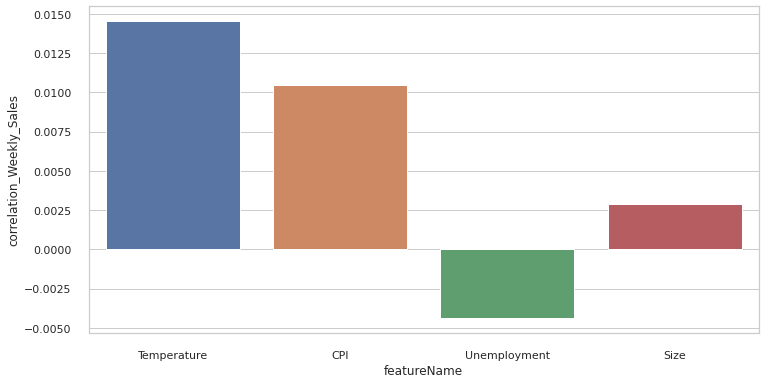

In [119]:
plt.figure(figsize=(12, 6))

import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.barplot(x="featureName", y="correlation_Weekly_Sales", data=corr)


In [117]:
categoricalFeatures

['year', 'month', 'IsHoliday', 'Type', 'week']

In [102]:
Train_df.columns

Index(['Temperature', 'CPI', 'Unemployment', 'Size', 'Dept', 'Store',
       'Weekly_Sales', 'IsHoliday', 'year_2011', 'year_2012', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'Type_B', 'Type_C',
       'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8',
       'week_9', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14',
       'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_20',
       'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26',
       'week_27', 'week_28', 'week_29', 'week_30', 'week_31', 'week_32',
       'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38',
       'week_39', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44',
       'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_50',
       'week_51', 'week_52'],
      dtype='object')

In [146]:
from scipy.stats import f_oneway
 
# Running the one-way anova test between CarPrice and FuelTypes
# Assumption(H0) is that FuelType and CarPrices are NOT correlated
 
# Finds out the Prices data for each FuelType as a list
CategoryGroupLists=Train_df.groupby('year')['Weekly_Sales'].apply(list)
 
# Performing the ANOVA test
# We accept the Assumption(H0) only when P-Value &gt; 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  3.2084516939716434e-18


In [123]:
from scipy.stats import f_oneway


categoricalPValue = []

for i in categoricalFeatures:
    CategoryGroupLists=Train_df.groupby(i)['Weekly_Sales'].apply(list)

    # Performing the ANOVA test
    # We accept the Assumption(H0) only when P-Value &gt; 0.05
    AnovaResults = f_oneway(*CategoryGroupLists)
    categoricalPValue.append(AnovaResults[1])
    
plt.figure(figsize=(12, 6))

import seaborn as sns
anovaResult =  pd.DataFrame(
    {'featureName': categoricalFeatures,
     'pValues': categoricalPValue
    })
anovaResult

,featureName,pValues
0,year,3.208452e-18
1,month,4.833068e-174
2,IsHoliday,2.124637e-12
3,Type,0.000000e+00
4,week,0.000000e+00


<Figure size 864x432 with 0 Axes>

In [142]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [167]:

categoricalData_train = Train_df[categoricalFeatures]

categoricalData_test = Test_df[categoricalFeatures]




ohE = OneHotEncoder(handle_unknown='ignore',sparse = False).fit(categoricalData_train)

categoricalData_train_transform = ohE.transform(categoricalData_train)
categoricalData_test_transform = ohE.transform(categoricalData_test)



In [173]:
stdSc = StandardScaler().fit(numericalData_train)

numericalData_train = Train_df[numericalFeatures]

numericalData_test = Test_df[numericalFeatures]



numericalData_train_transform = stdSc.transform(numericalData_train)
numericalData_test_transform = stdSc.transform(numericalData_test)



In [172]:
numericalData_train_transform[0].shape

(4,)

In [176]:
X_train = np.hstack([categoricalData_train_transform,numericalData_train_transform])
X_test = np.hstack([categoricalData_test_transform,numericalData_test_transform])

y_train = Train_df['Weekly_Sales'].values
y_test = Test_df['Weekly_Sales'].values

In [177]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(X_train, y_train)


y_predict = model.predict(X_test)

In [178]:
from sklearn.metrics import mean_squared_error, r2_score

rms = mean_squared_error(y_test, y_predict, squared=False)

rms

21916.33607032668

In [180]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_predict)

r2

0.072459722970864

In [143]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OneHotEncoder())
])

In [144]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numericalFeatures)
   ,('categorical', categorical_transformer, categoricalFeatures)
]) 

In [181]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',LinearRegression())
           ])

In [189]:
X_train = Train_df[numericalFeatures+categoricalFeatures]
y_train = Train_df['Weekly_Sales']

In [190]:
X_train

,Temperature,CPI,Unemployment,Size,year,month,IsHoliday,Type,week
247427,28.24,136.533516,7.598,152513,2011,12,0,A,50
149704,38.02,197.045721,6.162,57197,2012,3,0,B,11
289040,87.57,214.836868,7.852,42988,2011,7,0,C,26
170540,68.11,136.274581,8.890,120653,2011,9,1,B,36
397604,90.32,126.126600,9.524,39690,2010,6,0,C,25
...,...,...,...,...,...,...,...,...,...
370075,83.96,210.210842,8.464,184109,2010,6,0,A,24
277279,39.42,132.756667,10.524,93638,2010,12,0,B,48
224463,35.23,136.478800,4.420,114533,2011,11,1,B,47
58346,48.33,221.489341,6.132,202505,2012,1,0,A,2


In [191]:
reg_model = pipeline.fit(X_train,y_train)
print (reg_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Temperature', 'CPI',
                                                   'Unemployment', 'Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                

In [192]:
from sklearn.metrics import r2_score
y_test = Test_df['Weekly_Sales']
predictions = reg_model.predict(Test_df[numericalFeatures+categoricalFeatures])
print (r2_score(y_test, predictions))

0.0725255200644016
